# Detecção de Intrusões em Redes Usando Isolation Forest

## 1. Introdução

A segurança em redes de computadores é essencial para proteger sistemas contra ameaças como DoS, DDoS e varreduras de portas, que podem comprometer a integridade e disponibilidade dos serviços. Técnicas de aprendizado de máquina, como Random Forest, são eficazes na detecção automática de intrusões por meio da análise de padrões em dados de tráfego de rede. Este trabalho aplica o Random Forest para classificar eventos de rede, visando melhorar a identificação rápida e precisa de ataques cibernéticos.    

## 2. Fundamentação Teórica

Neste estudo, será utilizada a técnica de **Isolation Forest**, uma abordagem não supervisionada voltada para a detecção de anomalias. Esse método isola observações atípicas por meio da construção de múltiplas árvores de partição aleatória, identificando instâncias que exigem menos divisões para serem isoladas. O Isolation Forest é reconhecido por sua eficiência em conjuntos de dados tabulares e por sua capacidade de detectar comportamentos anômalos sem a necessidade de rótulos previamente definidos.

## 3. Metodologia

O dataset escolhido foi retirado da plataforma Kaggle:  
> [Network Intrusion Detection Dataset](https://www.kaggle.com/datasets/sampadab17/network-intrusion-detection)

O conjunto contém registros de tráfego de rede rotulados como normal ou pertencentes a diferentes tipos de ataques.

As etapas metodológicas incluem:

- Carregamento e visualização dos dados
- Limpeza e pré-processamento
- Treinamento do modelo
- Avaliação usando métricas padrão
    

# Carregando Dados

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.ensemble import IsolationForest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# ============================================================
# 1. Carregar e Preparar Dados (Melhoria na Divisão)
# ============================================================
df = pd.read_csv("Train_data.csv")

X = df.drop("class", axis=1)
# 0 para 'normal' (inlier) e 1 para 'anomaly' (outlier)
y = df["class"].map({"normal": 0, "anomaly": 1})

# Contagem da proporção real de anomalias (contamination) no dataset completo
# Este valor será usado como parâmetro do modelo para definir o limite de corte.
anomaly_rate = y.value_counts(normalize=True).get(1, 0)

# Divisão de treino/teste: Usar 'stratify=y' para manter a proporção de classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Pré-Processamento

In [57]:

# ============================================================
# 2. Pré-processamento e Pipeline
# ============================================================
categoricas = ["protocol_type", "service", "flag"]
numericas = list(set(X.columns) - set(categoricas))

# Colunas numéricas serão padronizadas (StandardScaler) e categóricas com OneHotEncoder
preprocessamento = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categoricas),
        ("num", StandardScaler(), numericas)
    ],
    remainder='passthrough'
)

# 3. Pipeline com Isolation Forest
# O Isolation Forest será configurado com a taxa real de anomalias (~0.47)
model = Pipeline([
    ("prep", preprocessamento),
    ("iforest", IsolationForest(
        n_estimators=200,
        contamination=anomaly_rate, # Usar a proporção real de anomalias
        random_state=42,
        # O parâmetro max_samples também pode ser otimizado
        max_samples='auto'
    ))
])


# Treinamento

In [58]:

# ============================================================
# 4. Treinamento (Apenas em Dados Normais)
# ============================================================

# Filtrar o conjunto de treino para conter APENAS amostras 'normais' (0)
# Esta é a principal refatoração para o uso correto do iForest.
X_train_normal = X_train[y_train == 0]

# Treinar a Pipeline (incluindo o StandardScaler e o IsolationForest)
# somente com o comportamento 'normal'
print(f"Iniciando o treinamento do Isolation Forest (contamination: {anomaly_rate*100:.2f}%)")
print(f"Modelo treinado em {len(X_train_normal)} amostras normais.")
model.fit(X_train_normal)


Iniciando o treinamento do Isolation Forest (contamination: 46.61%)
Modelo treinado em 10759 amostras normais.


,steps,"[('prep', ...), ('iforest', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Predição e Avaliação


=== Resultados do Isolation Forest ===
Acurácia: 0.7481643183171264
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.53      0.69      2690
           1       0.65      1.00      0.79      2349

    accuracy                           0.75      5039
   macro avg       0.82      0.76      0.74      5039
weighted avg       0.84      0.75      0.74      5039


Confusion Matrix:
[[1421 1269]
 [   0 2349]]


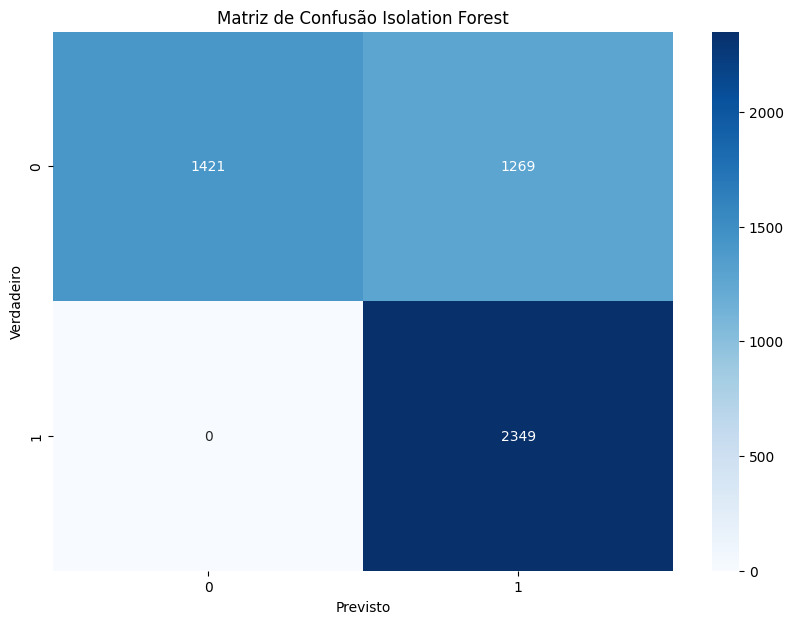


ROC AUC (Scores): 0.9814


In [59]:

# ============================================================
# 5. Predição e Avaliação
# ============================================================

# Predição: Aplicar no conjunto de teste completo (normal + anomalia)
pred_raw = model.predict(X_test)

# Converter: -1 (outlier/anomalia) para 1, e 1 (inlier/normal) para 0
y_pred = np.where(pred_raw == -1, 1, 0)

# A métrica mais importante (ROC AUC) é calculada usando o score de decisão, 
# que mede a 'anomalia' de cada ponto.
# Scores: negativos para inliers (normais) e positivos para outliers (anomalias).
# O sinal negativo inverte para que valores maiores signifiquem mais anomalia.
scores = -model["iforest"].decision_function(model["prep"].transform(X_test))
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, scores)

print("\n=== Resultados do Isolation Forest ===")
print(f"Acurácia: {acc}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm=confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão Isolation Forest")
plt.show()

print(f"\nROC AUC (Scores): {auc:.4f}")


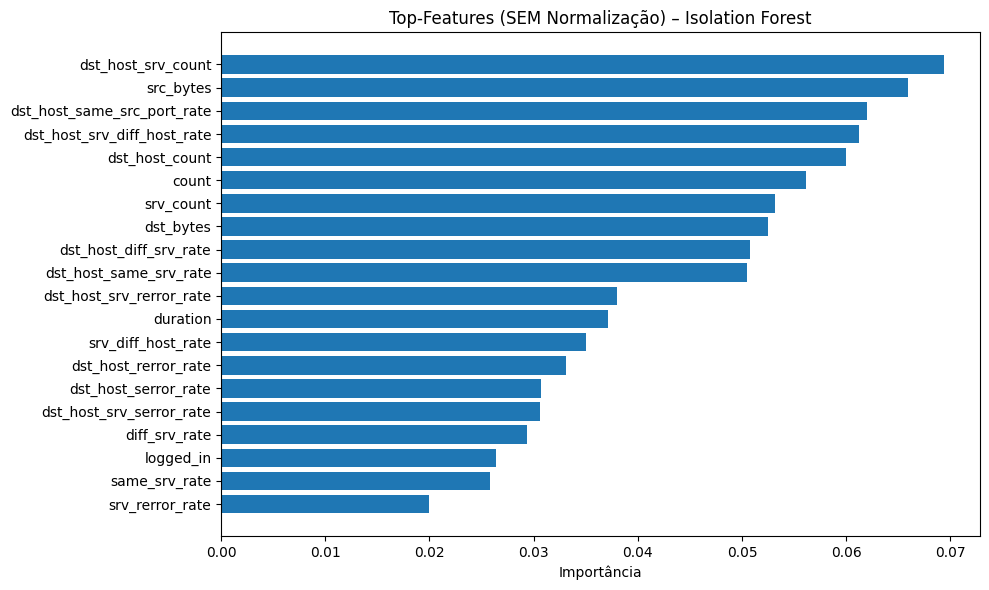

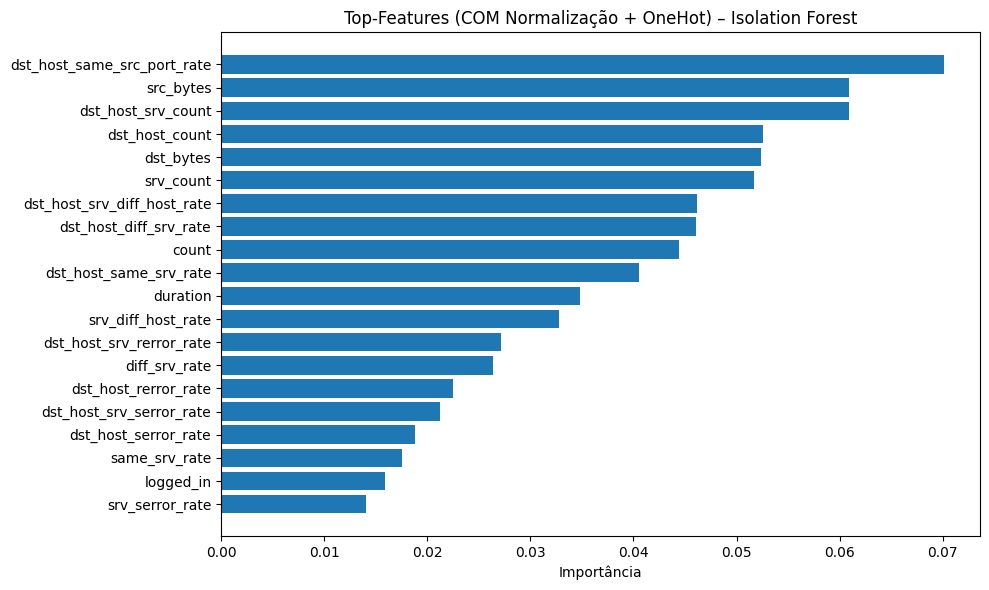

In [60]:

# ============================================================
# 7. IMPORTÂNCIA dos FEATURES (com e sem normalização) - ORDENADO
# ============================================================

# -----------------------------
# Função para extrair importâncias do IF (MDI)
# -----------------------------
def get_iforest_feature_importance(model, feature_names):
    """
    Retorna a importância média das features somando a importance do ensemble.
    """
    importances = np.zeros(len(feature_names))

    # cada árvore tem .feature_importances_
    for est in model.estimators_:
        importances += est.feature_importances_

    importances = importances / len(model.estimators_)
    return importances

top_n = 20  # quantidade de features no gráfico

# ============================================================
# SEM normalização (apenas numéricas)
# ============================================================
model_sem_norm = IsolationForest(
    n_estimators=200,
    contamination=anomaly_rate,
    random_state=42
)

model_sem_norm.fit(X_train_normal[numericas])

importancias_sem = get_iforest_feature_importance(model_sem_norm, numericas)

# Ordenar
idx_sem = np.argsort(importancias_sem)[::-1]  # do maior → menor
numericas_ordenadas = [numericas[i] for i in idx_sem]
import_sem_ordenado = importancias_sem[idx_sem]

plt.figure(figsize=(10, 6))
plt.barh(numericas_ordenadas[:top_n], import_sem_ordenado[:top_n])
plt.title("Top-Features (SEM Normalização) – Isolation Forest")
plt.xlabel("Importância")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ============================================================
# COM normalização + OneHot
# ============================================================

# nomes das features após transformar
nome_features = (
    list(model["prep"].named_transformers_["cat"].get_feature_names_out(categoricas))
    + numericas
)

importancias_com = get_iforest_feature_importance(
    model["iforest"], nome_features
)

# ordenar
idx_com = np.argsort(importancias_com)[::-1]
features_ordenadas = [nome_features[i] for i in idx_com]
import_com_ordenado = importancias_com[idx_com]

plt.figure(figsize=(10, 6))
plt.barh(features_ordenadas[:top_n], import_com_ordenado[:top_n])
plt.title("Top-Features (COM Normalização + OneHot) – Isolation Forest")
plt.xlabel("Importância")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



### Observação:
- O primeiro gráfico mostra as diferenças absolutas nas unidades originais das features.
- O segundo gráfico mostra as diferenças relativas (dados padronizados).
- Normalizamos no Isolation Forest para que todas as features tenham igual influência na detecção de anomalias, evitando que a escala de uma variável distorça o isolamento.
- A normalização evita que atributos com escala grande (ex.: bytes, tempo) dominem o resultado.
- Assim, o segundo gráfico costuma refletir melhor as features mais relevantes para a detecção de anomalias.